In [1]:
import numpy as np
import math 
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

# Problem 1: Implementing 2D convolution in Python.

In [2]:
def read_image(file_name):
    #float convert 
    img = cv2.imread(file_name,0)   
    img = img.astype(float)
    return img

In [3]:
# a)
def conv2d(image, kernel):
    x, y = kernel.shape
    #pad
    padded_image = np.pad(image, ((x//2, x//2), (y//2, y//2)), mode='constant')
    a, b = padded_image.shape
    convoluted_image = np.zeros((a-x+1, b-y+1))
    for i in range(a-x+1):
        for j in range(b-y+1):
            convoluted_image[i][j] = np.sum(kernel * padded_image[i:i + x, j:j + y])

    #normalize
    convoluted_image = ((convoluted_image - np.min(convoluted_image)) / (np.max(convoluted_image) - np.min(convoluted_image)) * 255).astype('uint8')

    
    return convoluted_image

In [4]:
# The log-magnitude spectrum graphs are based on this guide by opencv: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html
# b)
def plot_filtering(image, filter):
    #For your filter-response, use an FFT size equal to the size of your image.
    x = [image.shape[0], image.shape[1]]
    convoluted_image = conv2d(image,filter)
    
    #calculate the magnitude spectrum for original image, filtered image and the filter.
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift)+1)
    
    f2 = np.fft.fft2(convoluted_image)
    fshift2 = np.fft.fftshift(f2)
    magnitude_spectrum2 = 20*np.log(np.abs(fshift2)+1)
    
    f3 = np.fft.fft2(filter, x)
    fshift3 = np.fft.fftshift(f3)
    magnitude_spectrum3 = 20*np.log(np.abs(fshift3)+1)
    
    #original & filtered image plot
    a,plot1 = plt.subplots(1,2,figsize=(20,20))
    plot1[0].imshow(image,cmap='gray')
    plot1[0].set_title("Original Image")
    plot1[1].imshow(convoluted_image,cmap='gray')
    plot1[1].set_title("Filtered Image")
    
    #plot all three magnitude spectrum.
    b,plot2 = plt.subplots(1,3,figsize=(20,20))
    plot2[0].imshow(magnitude_spectrum,cmap='gray') 
    plot2[0].set_title("Magnitude Spectrum of Original Image")
    plot2[1].imshow(magnitude_spectrum2,cmap='gray')
    plot2[1].set_title("Magnitude Spectrum of Filtered Image")
    plot2[2].imshow(magnitude_spectrum3,cmap='gray')
    plot2[2].set_title("Magnitude Spectrum of Filter")

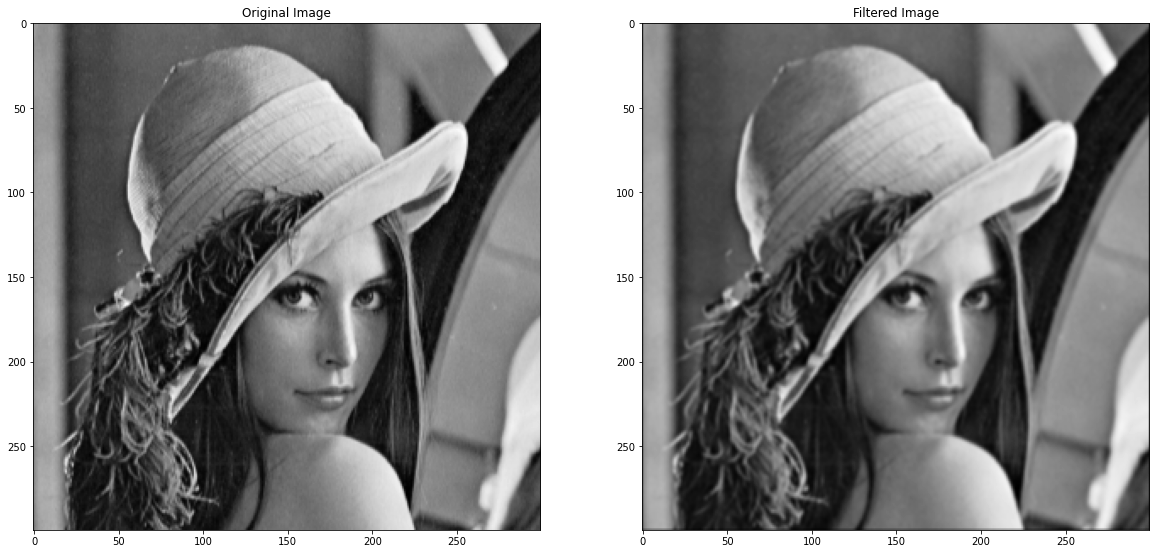

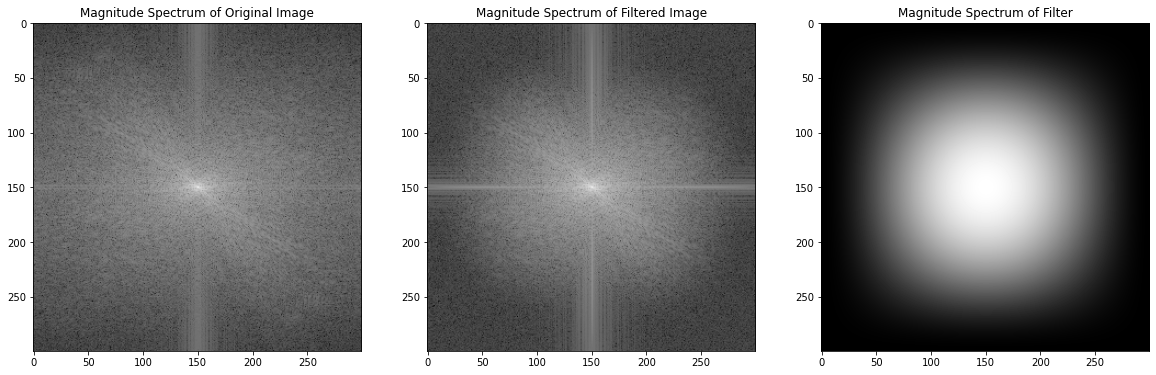

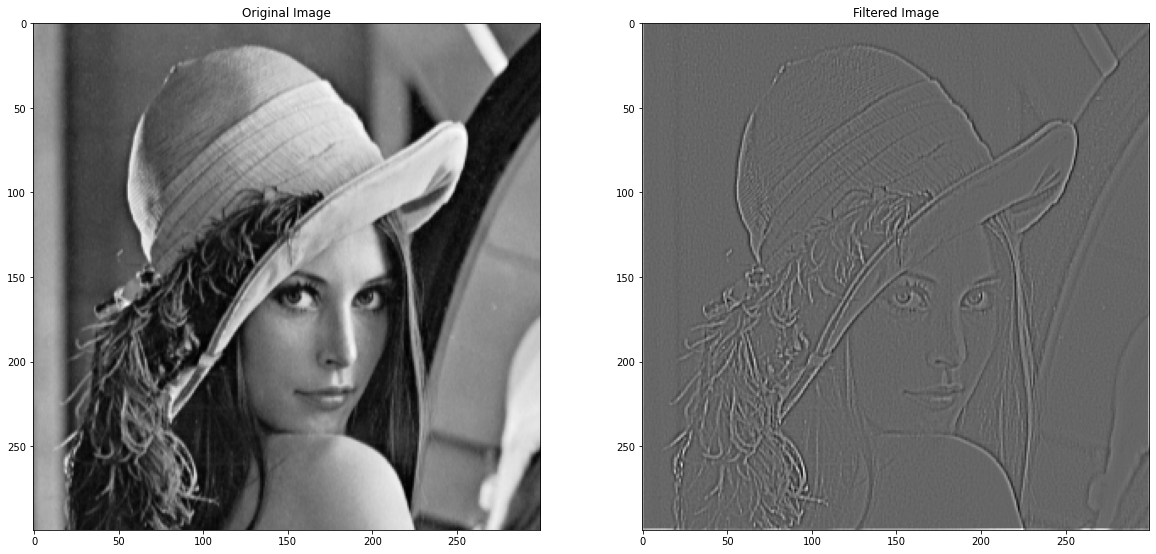

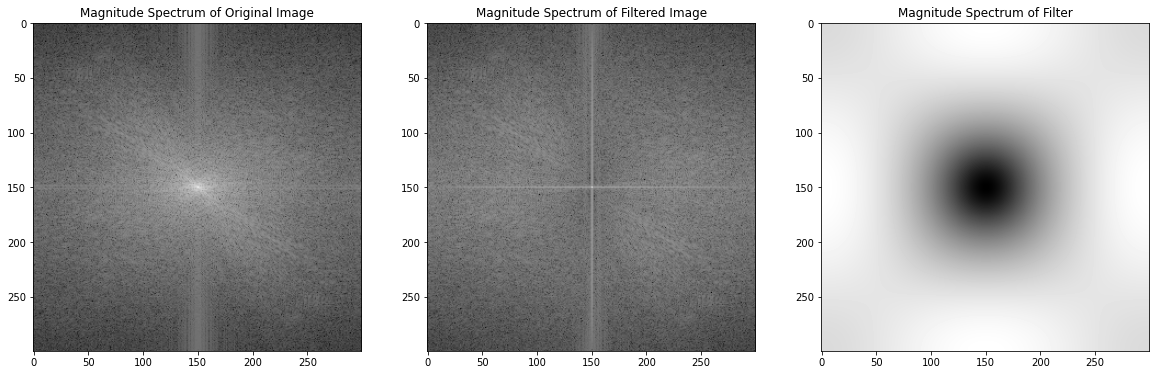

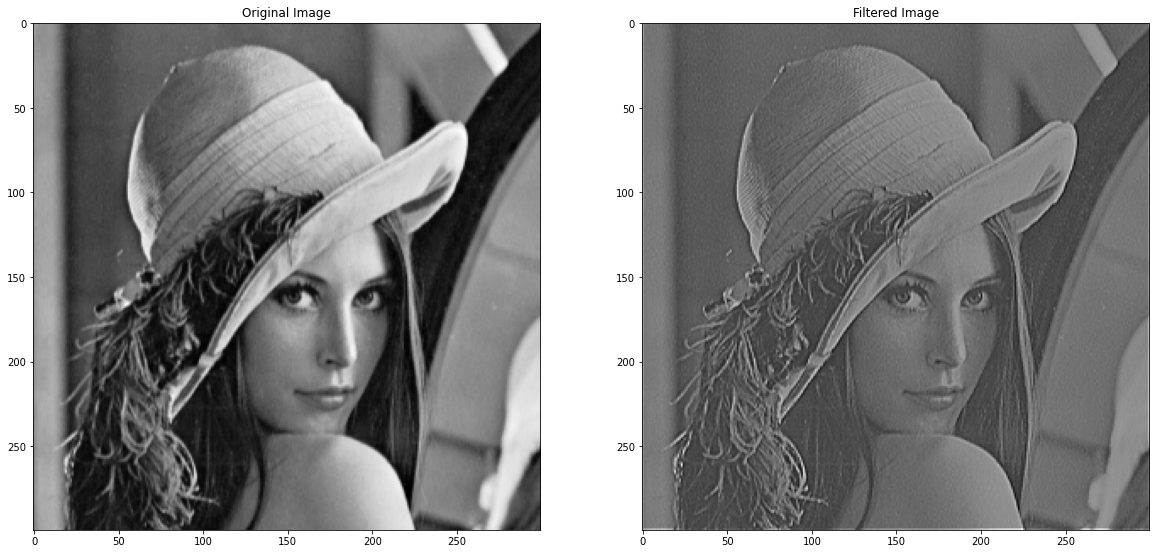

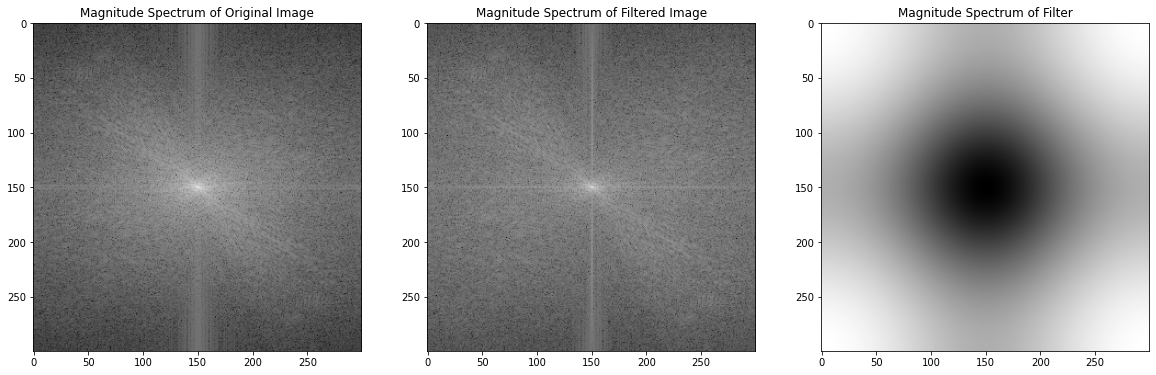

In [5]:
# c) Explaination is located below output
def QUEST1():
    img = read_image("lena.png")
    filter = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
    filter2 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
    filter3 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    plot_filtering(img,filter)
    plot_filtering(img,filter2)
    plot_filtering(img,filter3)

QUEST1()

For each filter, discuss the result of filtering in both spatial and frequency domains \
1/ First Filter: all coefficients sum to 1 with positive coefficients.
- Spatial Domain: Averaging the pixel values in a local neighborhood, reducing high-frequency noise and sharp edges in the image, resulting in a softer, blurred appearance. 
- Frequency Domain: Low-pass filtering it can be used for noise removal or image smoothing




2/ Second Filter: all coefficients sum to 0.
- Spatial Domain: Enhancing edges and fine details in the image and increasing the contrast between neighboring pixels.
- Frequency Domain: High-pass filtering and is used for edge detection



3/ Third Filter: coefficients sum to 1 with negative coefficients
- Spatial Domain: Enhancing high-frequency components corresponding to edges and suppressing low-frequency components.
- Frequency Domain: high emphasis filter used for edge sharping. 

# Problem 2: Image denoising with average and Gaussian filters

In [6]:
#a)
def awgn(image, sigma):
    shape = image.shape
    #scale 0-255
    noise = np.random.normal(0,sigma*255,shape)
    return np.add(image, noise)

In [7]:
#b)
def gaussian_filter(m, sigma):
    #gauss filter
    ax = np.arange(-m//2+1, m//2+1)
    gauss = np.exp(-0.5*np.square(ax)/np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [8]:
#c)
def avg_filter(m):
    #average filter
    return np.ones((m,m))/m**2

In [9]:
#c)
def PSNR(o_image, n_image):
    # # #resize because for the denoise image have a different dimension.
    n_image = cv2.resize(n_image, (o_image.shape[1], o_image.shape[0]))
    # # #from 0 to 1 to use the formula given in the question
    o_image = o_image/255
    n_image = n_image/255
    err = np.sum((o_image.astype("float") - n_image.astype("float")) ** 2)
    MSE = err/(float(o_image.shape[0] * o_image.shape[1]))
    return (-10*math.log10(MSE))

The experiment results for part c with intense noise levels of 0.1, 0.2, 0.3 (with gaussian and average filters size 5x5, 6x6, 7x7 for each) can be seen below. At noise level 1, the gaussian filter size 5x5 has the highest PSNR. With noise level sigma = 0.1. Both average and gaussian filter achive overal noise removal, but gaussian filter reduces noise while preserving the overall structure and details of the image. After all the test cases, we see this trend continues. In all noise levels and sizes:
- The Gaussian filter is more effective at preserving edges and fine details in the image while reducing noise. 
- The average filter treats all pixels within the kernel equally, reducing overall image sharpness along with noise.
Although the overall sharpness of the average filter cases is lower compare to gausian filter cases', it still do a good job removing the noise. Thus, both are capable of removing noise but gausian filter is a better choice if details are priority.

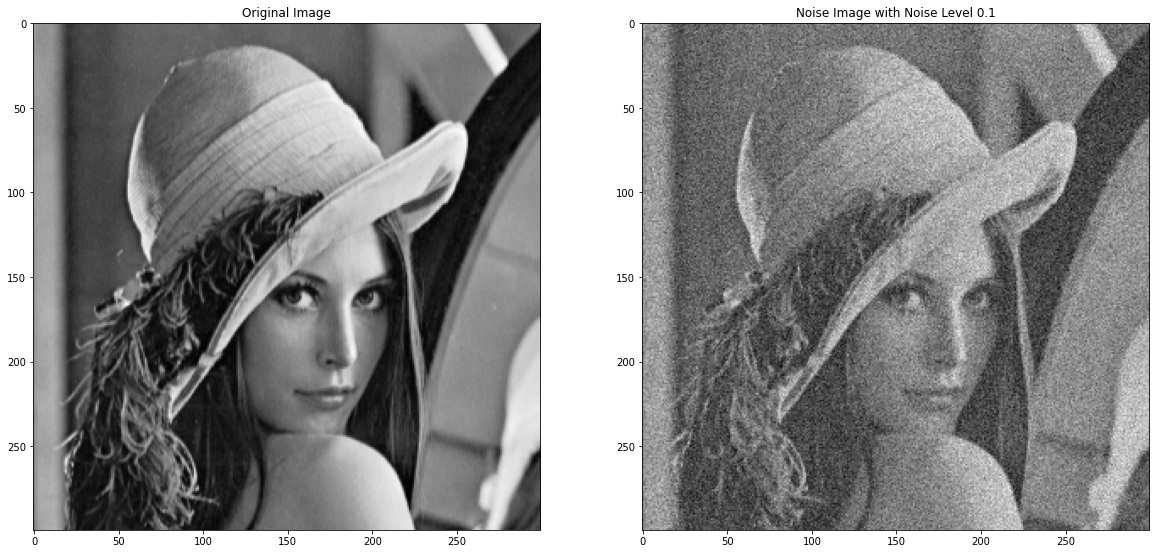

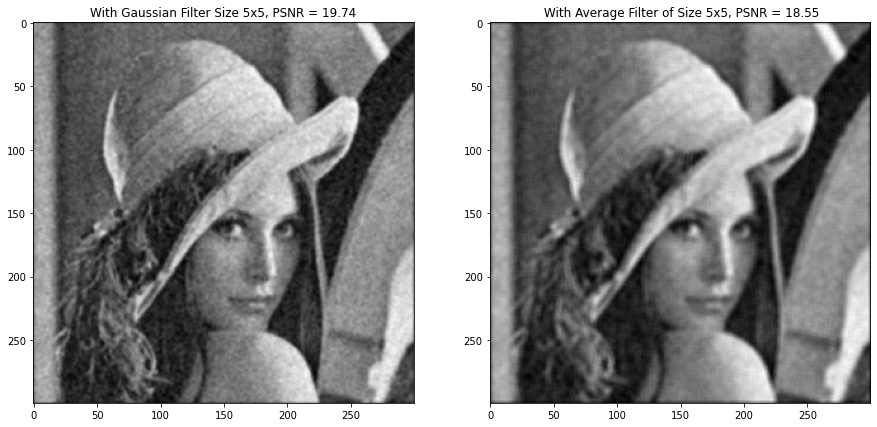

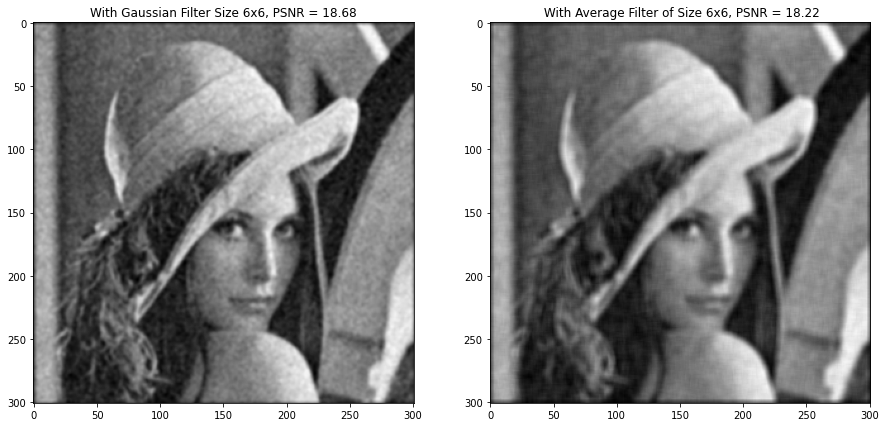

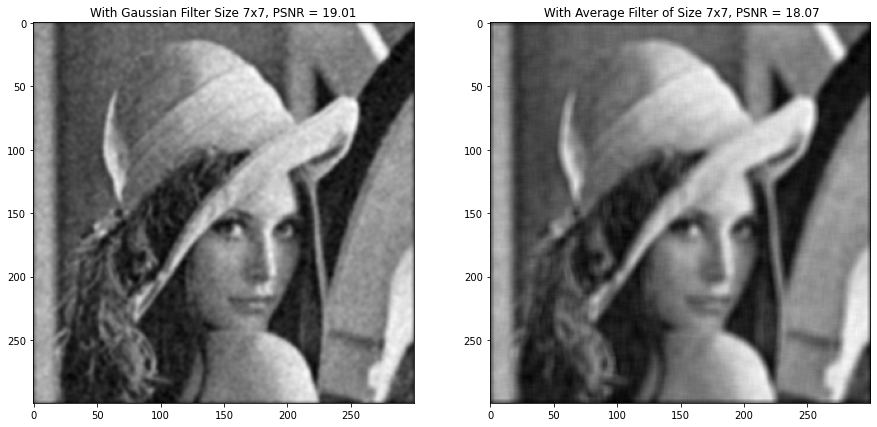

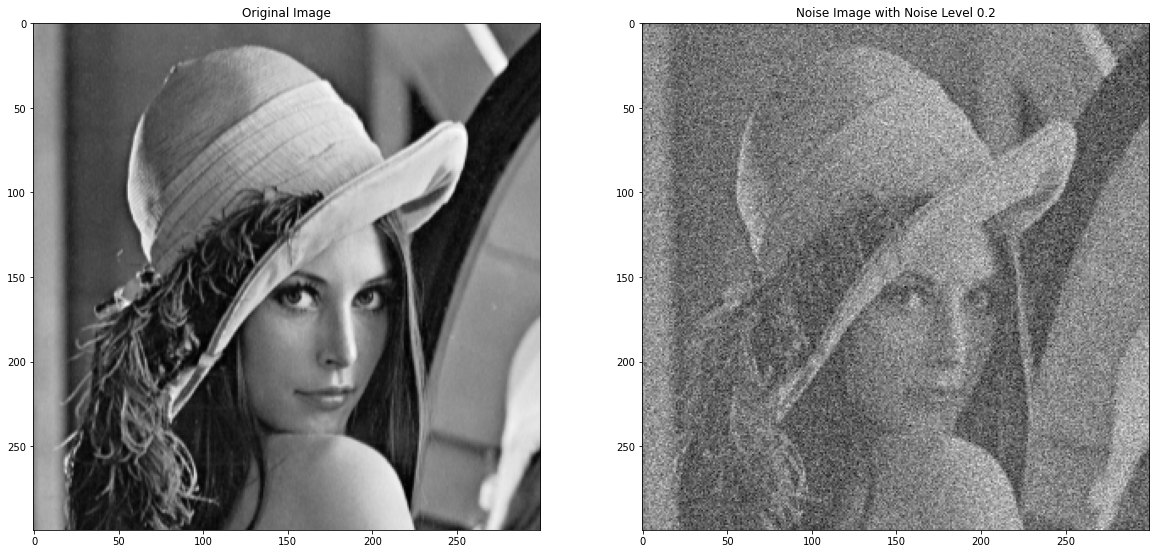

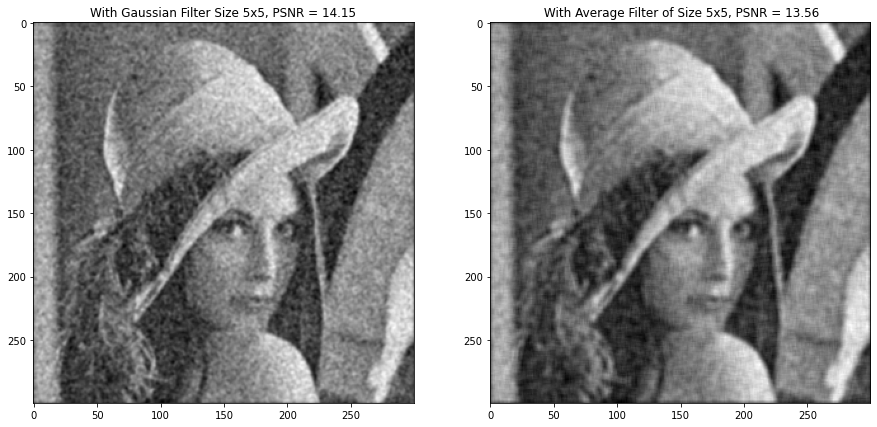

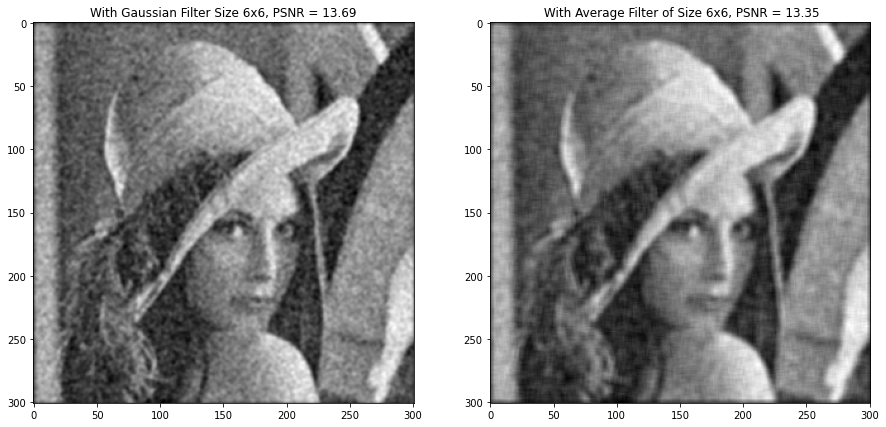

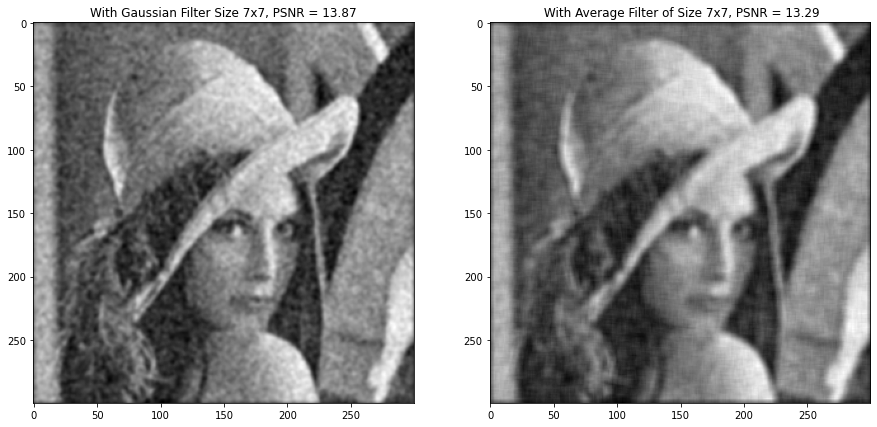

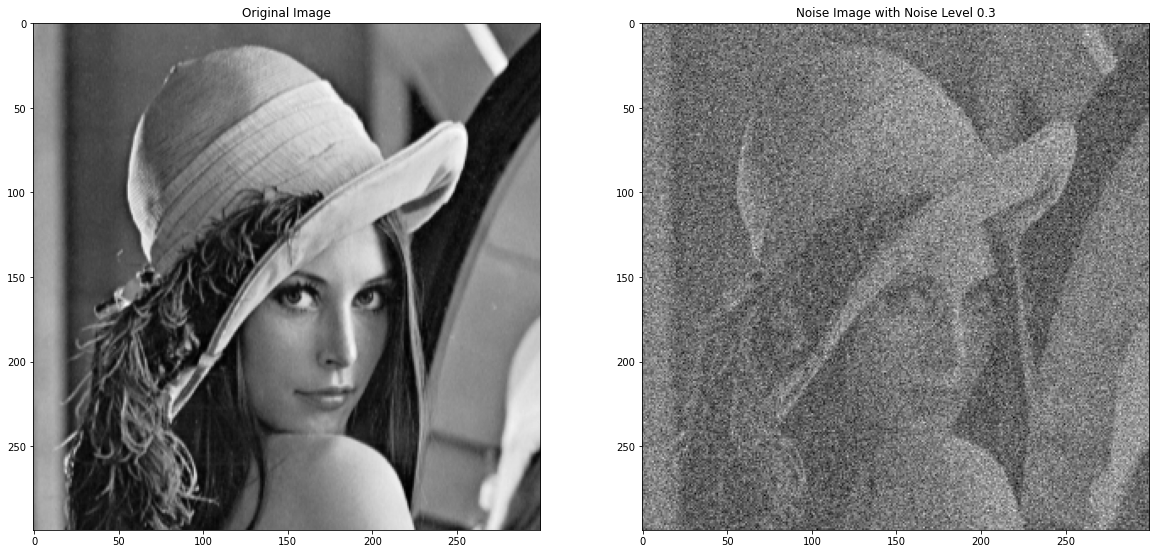

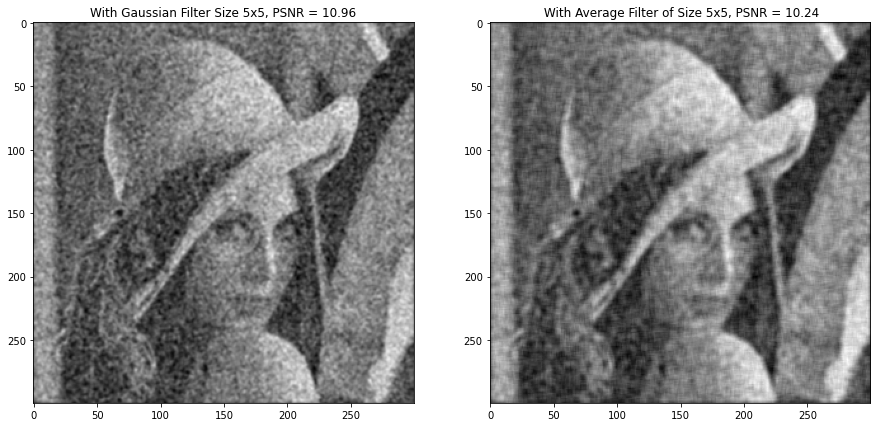

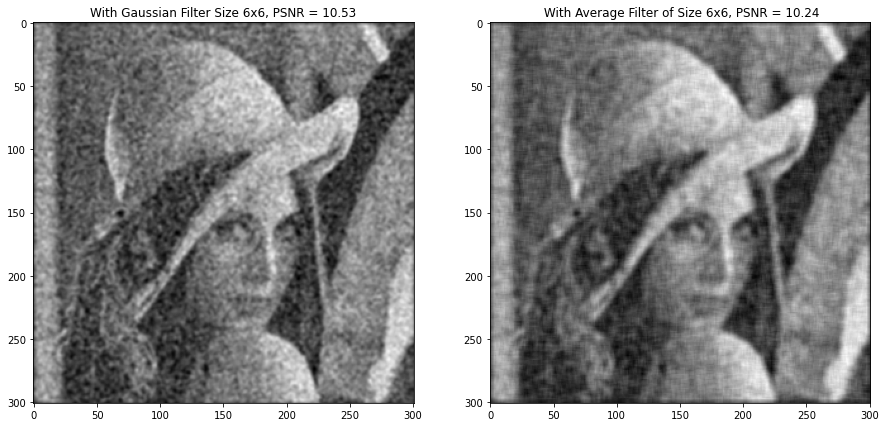

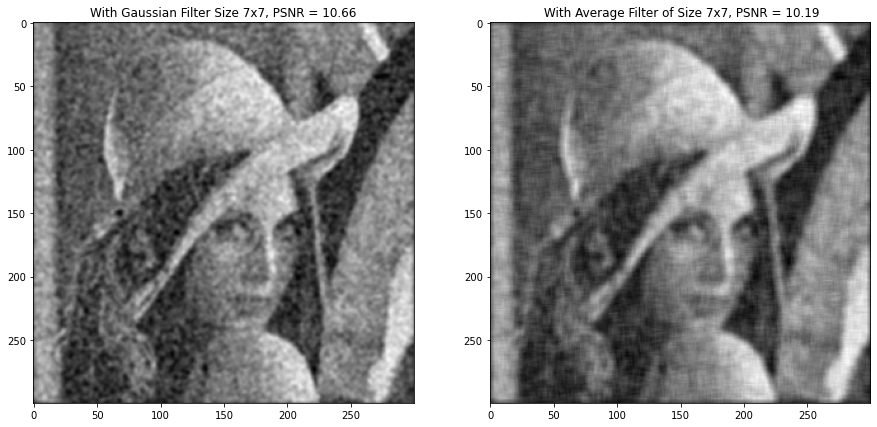

In [10]:
#c)
def QUEST2():
    img = read_image("lena.png")
    #different intense levels
    intense_level = [0.1,0.2,0.3]
    #different filter sizes
    filter_size = [5,6,7]
    for i in intense_level:
        #original & filtered image plot
        noiseimg = awgn(img, i)
        a,plot1 = plt.subplots(1,2,figsize=(20,20))
        plot1[0].imshow(img,cmap='gray')
        plot1[0].set_title("Original Image")
        plot1[1].imshow(noiseimg,cmap='gray')
        plot1[1].set_title("Noise Image with Noise Level {}".format(i))
        for j in filter_size:
            #get filtered images
            
            g_filter = gaussian_filter(j, j/5)
            a_filter = avg_filter(j)
            
            #get denoise image
            img_gauss = conv2d(noiseimg, g_filter)
            img_avg = conv2d(noiseimg, a_filter)
            # img_gauss = signal.convolve2d(noiseimg, g_filter)
            # img_avg = signal.convolve2d(noiseimg, a_filter)
            #score between noise image and denoise image
            PSNR1 = round(PSNR(noiseimg, img_gauss),2)
            PSNR2 = round(PSNR(noiseimg, img_avg),2)
            b,plot2 = plt.subplots(1,2,figsize=(15,15))
            plot2[0].imshow(img_gauss,cmap='gray')
            plot2[0].set_title("With Gaussian Filter Size {}x{}, PSNR = {}".format(j,j,PSNR1))
            plot2[1].imshow(img_avg,cmap='gray')
            plot2[1].set_title(" With Average Filter of Size {}x{}, PSNR = {}".format(j,j, PSNR2))
QUEST2()